In [57]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from scipy.optimize import minimize
import api

# Section 1 -- Define tickers and time period
## How can i create a portfolio with the highest risk adjusted return?


## Define the list of tickers

In [3]:
tickers = ['SPY', 'BND','GLD','QQQ','VTI']

In [4]:
end_date = datetime.today()

## Set start date 5 years ago

In [5]:
start_date = end_date - timedelta(days=365*5)
start_date

datetime.datetime(2020, 6, 12, 9, 6, 50, 135073)

# Section 2: download Adjusted Close Prices

## Create an empty DataFrame to store the adj close prices

### Adj close is more representative of overall returns as they include dividents and stock splits

In [6]:
adj_close_df = pd.DataFrame()

## Download close price for each of the tickers

In [26]:
for ticker in tickers:
    data = yf.download(ticker, start=start_date, end=end_date, auto_adjust=False)
    adj_close_df[ticker] = data['Adj Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [27]:
# Check adj close_df
print(adj_close_df.head())

                   SPY        BND         GLD         QQQ         VTI
Date                                                                 
2020-06-12  282.848114  76.069122  162.619995  228.909180  142.906311
2020-06-15  285.488739  76.225128  162.330002  231.694382  144.437729
2020-06-16  290.983643  76.129791  162.250000  235.673248  147.212936
2020-06-17  289.774933  76.147118  162.559998  236.420456  146.498230
2020-06-18  289.886536  76.233765  162.240005  237.060959  146.618866


# Section 3: Calculate Log normal returns for each ticker

In [31]:
log_returns_df = np.log(adj_close_df / adj_close_df.shift(1))
# Check log returns
print(log_returns_df.head())
print(log_returns_df.count())

                 SPY       BND       GLD       QQQ       VTI
Date                                                        
2020-06-12       NaN       NaN       NaN       NaN       NaN
2020-06-15  0.009293  0.002049 -0.001785  0.012094  0.010659
2020-06-16  0.019064 -0.001252 -0.000493  0.017027  0.019032
2020-06-17 -0.004163  0.000228  0.001909  0.003166 -0.004867
2020-06-18  0.000385  0.001137 -0.001970  0.002706  0.000823
SPY    1254
BND    1254
GLD    1254
QQQ    1254
VTI    1254
dtype: int64


## Drop missing values

In [32]:
log_returns_df = log_returns_df.dropna()
log_returns_df.count()

SPY    1254
BND    1254
GLD    1254
QQQ    1254
VTI    1254
dtype: int64

# Section 4: Calculate Covariance Matrix

In [33]:
cov_matrix = log_returns_df.cov() * 252  # Annualize the covariance matrix
cov_matrix

,SPY,BND,GLD,QQQ,VTI
SPY,0.031124,0.001908,0.003896,0.038871,0.031622
BND,0.001908,0.003545,0.003089,0.002757,0.001997
GLD,0.003896,0.003089,0.023605,0.005226,0.004065
QQQ,0.038871,0.002757,0.005226,0.055343,0.039562
VTI,0.031622,0.001997,0.004065,0.039562,0.032465


# Section 5: Portfolio performance metrics


## Calculate Portfolio Standard deviation

In [34]:
def standard_deviation(weights, cov_matrix):
    """
    Calculate the portfolio standard deviation.
    """
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

## Calculate Expected Return

Assuming expected returns are similar to historical returns

In [35]:
def expected_return(weights, log_returns_df):
    """
    Calculate the expected portfolio return.
    """
    return np.sum(log_returns_df.mean() * weights) * 252  # Annualize the return

## Calculate Sharpe Ratio

In [36]:
def sharpe_ratio(weights, log_returns_df, cov_matrix, risk_free_rate):
    """
    Calculate the Sharpe Ratio of the portfolio.
    """
    return(expected_return (weights, log_returns_df) - risk_free_rate) / standard_deviation(weights, cov_matrix)

## Calculate Sortino Ratio

In [37]:
def sortino_ratio(weights, log_returns_df, cov_matrix, risk_free_rate):
    """
    Calculate the Sortino Ratio of the portfolio.
    """
    downside_returns = log_returns_df[log_returns_df < 0]
    downside_deviation = np.sqrt(np.dot(weights.T, np.dot(downside_returns.cov() * 252, weights)))
    return (expected_return(weights, log_returns_df) - risk_free_rate) / downside_deviation

# Section 6: Portfolio Optimization

## Set Risk Free Rate

In [58]:

def get_risk_free_rate(api_key):
    """
    Fetch the risk-free rate from FRED.
    """
    import requests
    #using the 10-year Treasury yield as a proxy for the risk-free rate
    url = f'https://api.stlouisfed.org/fred/series/observations?series_id=GS10&api_key={api.FRED_API_KEY}&file_type=json'
    response = requests.get(url)
    data = response.json()
    rate = float(data['observations'][-1]['value']) / 100  # Convert percentage to decimal
    return rate
risk_free_rate = get_risk_free_rate(fred_api_key)

In [59]:
risk_free_rate

0.044199999999999996

## Define Function to minimize

### Negative sharpe ratio

we use the scipy.optimize.minimize() function to minimize the value

In [47]:
def negative_sharpe_ratio(weights, log_returns_df, cov_matrix, risk_free_rate):
    """
    Objective function to minimize: negative Sharpe Ratio.
    """
    return -sharpe_ratio(weights, log_returns_df, cov_matrix, risk_free_rate)

## Set Constrains and Bounds

constrains and conditions that must be met by the solution during the optimization process.

In [49]:
constrains = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})  # Weights must sum to 1

bounds = [(0, .5) for _ in range(len(tickers))]  # Weights must be between 0 and 1

## Set Initial weights

In [50]:
# can be changed to inputs by user

initial_weights = np.array([1/len(tickers)] * len(tickers))  # Equal weights

## Oprimize the weights to maximize the the sharpe ratio

In [51]:
optimized_result = minimize(negative_sharpe_ratio, initial_weights, args = (log_returns_df, cov_matrix, risk_free_rate),
                            method='SLSQP', bounds=bounds, constraints=constrains)

## Get optimal weights

In [52]:
optimal_weights = optimized_result.x


# Section 7: Analyze the Optimal Portfolio

## Display analytics of the optimal portfolio

In [53]:
print(optimal_weights)
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.2%}")
print()

optimal_portfolio_return = expected_return(optimal_weights, log_returns_df)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_portfolio_sharpe = sharpe_ratio(optimal_weights, log_returns_df, cov_matrix, risk_free_rate)

print(f"expected annual return: {optimal_portfolio_return: 4f}")
print(f"expected volatility: {optimal_portfolio_volatility: 4f}")
print(f"expected Sharpe Ratio: {optimal_portfolio_sharpe: 4f}")

[0.5 0.  0.5 0.  0. ]
SPY: 50.00%
BND: 0.00%
GLD: 50.00%
QQQ: 0.00%
VTI: 0.00%

expected annual return:  0.139828
expected volatility:  0.125021
expected Sharpe Ratio:  0.764898


## Display Final Portfolio as a Graph

Matplotlib is building the font cache; this may take a moment.


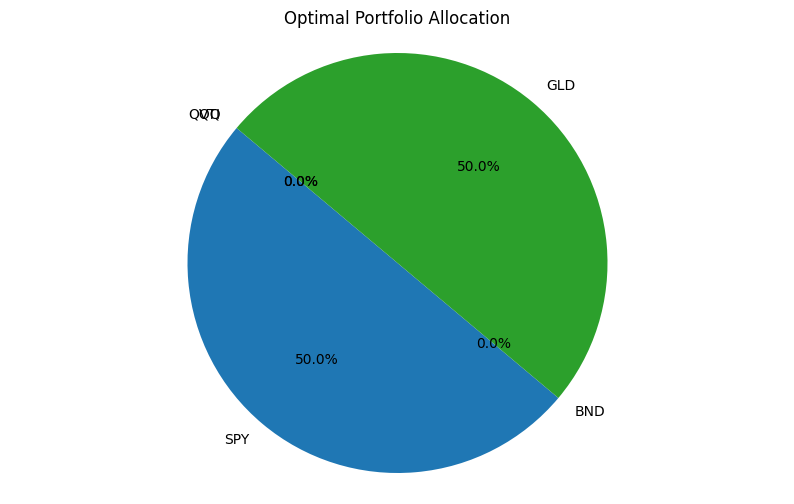

In [56]:
# display as a pie chart using matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.pie(optimal_weights, labels=tickers, autopct='%1.1f%%', startangle=140)
plt.title('Optimal Portfolio Allocation')
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is a circle.
plt.show()